### CS3405 Homework 3
#### Deep Learning Neural Networks
#### Due: Monday, November 19, 2018
##### 1. Implement a Convolutional Neural Network (CNN) that consists of convolutional layers and fully-connected (FC or MLP) layers
##### 2. Instantiate a [784, 50, 10] MLP and a LeNet-5-like CNN
##### 3. Train both MLP and CNN using the MNIST-60000 dataset
##### 4. Exploit the impact of hyperparameters (learning rate, batch size, activation function, etc) on training accuracy and training time

In [2]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pylab as plt
import time

In [3]:
class MLP(object):
    '''Multiple Layer Perceptron'''
    
    def __init__(self, Layers=(2, 5, 3), BatchSize = 4):
        self.bs = BatchSize
        self.net = [dict() for i in range(len(Layers))] # A list of fully-connected Layers
       
        self.net[0]['i'] = np.zeros((Layers[0], self.bs), dtype='float64')
        self.net[0]['z'] = np.zeros((Layers[0], self.bs), dtype='float64')
        self.net[0]['bnz'] = np.zeros((Layers[0], self.bs), dtype='float64')
        self.net[0]['a'] = np.zeros((Layers[0], self.bs), dtype='float64')    
            
        self.net[0]['dJdi'] = np.zeros(self.net[0]['i'].shape, dtype='float64')
        self.net[0]['dJdz'] = np.zeros(self.net[0]['z'].shape, dtype='float64') 
        self.net[0]['dJdbnz'] = np.zeros(self.net[0]['bnz'].shape, dtype='float64')
        self.net[0]['dJda'] = np.zeros(self.net[0]['a'].shape, dtype='float64')
        
        for i in range(1, len(Layers), 1):
            self.net[i]['i'] = np.zeros((Layers[i-1], self.bs), dtype='float64')
            self.net[i]['z'] = np.zeros((Layers[i], self.bs), dtype='float64')
            self.net[i]['bnz'] = np.zeros((Layers[i], self.bs), dtype='float64')
            self.net[i]['a'] = np.zeros((Layers[i], self.bs), dtype='float64')
            self.net[i]['W'] = np.random.randn(Layers[i], Layers[i-1]).astype('float64')
            self.net[i]['b'] = np.random.randn(Layers[i], 1).astype('float64')
            self.net[i]['gamma'] = np.random.randn(Layers[i], 1).astype('float64')
            self.net[i]['beta'] = np.random.randn(Layers[i], 1).astype('float64')
            
            self.net[i]['dJdi'] = np.zeros(self.net[i]['i'].shape, dtype='float64')
            self.net[i]['dJdz'] = np.zeros(self.net[i]['z'].shape, dtype='float64')
            self.net[i]['dJdbnz'] = np.zeros(self.net[i]['bnz'].shape, dtype='float64')
            self.net[i]['dJda'] = np.zeros(self.net[i]['a'].shape, dtype='float64')
            self.net[i]['dJdW'] = np.zeros(self.net[i]['W'].shape, dtype='float64')
            self.net[i]['dJdb'] = np.zeros(self.net[i]['b'].shape, dtype='float64')
            self.net[i]['dJdgamma'] = np.zeros(self.net[i]['gamma'].shape, dtype='float64')
            self.net[i]['dJdbeta'] = np.zeros(self.net[i]['beta'].shape, dtype='float64')
        
        self.p = np.zeros(self.net[-1]['a'].shape, dtype='float64') # Softmax Output
        self.dJdp = np.zeros(self.p.shape, dtype='float64')
        
        self.yhat = np.zeros(self.bs, dtype=int) # Predicted Answer
        self.y_onehot = np.zeros(self.p.shape, dtype=int) # One-Hot-Encoded Predicted Answer
        
        self.J = [] # Loss value trace
        self.J_val = [] # Loss value trace for validation
        self.L2_regularization = [] # L2 regularization value trace
        
    
    # Feed Forward Evaluation
    def forward(self, x):
        
        # For the input layer, Just copy input to Layer 0
        np.copyto(self.net[0]['i'], x)
        np.copyto(self.net[0]['z'], self.net[0]['i'])
        np.copyto(self.net[0]['bnz'], self.net[0]['z'])
        np.copyto(self.net[0]['a'], self.net[0]['bnz'])
        
        for i in range(1, len(self.net)): # Frome Layer 1 to the Last layer
             
            np.copyto(self.net[i]['i'], self.net[i-1]['a']) # Copy last layer's output 
            np.copyto(self.net[i]['z'],
                      np.dot(self.net[i]['W'], self.net[i]['i']) + self.net[i]['b'])           
            np.copyto(self.net[i]['bnz'], 
                      self.batch_norm(self.net[i]['z'],
                                      self.net[i]['gamma'],
                                      self.net[i]['beta'],
                                      0.01))  # 0.01 is epsilon
            np.copyto(self.net[i]['a'], 
                      self.ReLU(self.net[i]['bnz']))# Activation function
            
            
        np.copyto(self.p, self.softmax(self.net[-1]['a']))  # Softmax
        np.copyto(self.yhat, np.argmax(self.p, axis=0)) # Prediction result
        
        return
   
    # Batch Normalization for an MLP Layer
    # x --> bnx
    def batch_norm(self, x, gamma, beta, eps):
        
        bs = x.shape[-1]
        mu = 1.0/bs * np.sum(x, axis=-1)[:, None]
        u = x - mu
        sigma2 = 1.0/bs * np.sum(u ** 2, axis=-1)[:, None]
        q = sigma2 + eps
        v = np.sqrt(q)
        xhat = u / v
        bnx = gamma * xhat + beta
        
        return bnx
    
    # Backprop Batch Normalization for an MLP Layer
    # (dJdbnx, x, gamma, beta) --> (dJdbeta, dJdgamma, dJdx)
    def batch_norm_prime(self, dJdbnx, x, gamma, beta, eps):
        
        bs = x.shape[-1]
        mu = 1.0/bs * np.sum(x, axis=-1)[:, None]
        u = x - mu
        sigma2 = 1.0/bs * np.sum(u ** 2, axis=-1)[:, None]
        q = sigma2 + eps
        v = np.sqrt(q)
        xhat = u / v
        
        dJdbeta = np.mean(dJdbnx, axis=-1)[:, None]
        dJdgamma = np.mean(dJdbnx * xhat, axis=-1)[:, None]
        dJdx = (1.0 - 1.0/bs) * (1.0/v - u**2 / v**3 / bs) * gamma * dJdbnx
        
        return dJdbeta, dJdgamma, dJdx
    
    def softmax(self, a):
        return np.exp(a) / np.sum(np.exp(a), axis=0)
    
    # Sigmoid activation function: z --> a
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-1.0*z))
    
    # a --> dadz
    def sigmoidPrime(self, a):
        return a * (1.0 - a)
    
    def tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def tanhPrime(self, a):
        return (1.0 - a ** 2) # Derivative of tanh is (1.0 - tanh ** 2)
    
    def swish(self, z):
        return z * self.sigmoid(z)
    
    def swishPrime(self, a, z):
        return a + self.sigmoid(z) * (1.0 - a) 
    
    def ReLU(self, z):
        a = np.copy(z)
        a[a<0] = 0.0
        return a
    
    def ReLUPrime(self, a):
        dadz = np.copy(a)
        dadz[a>0] = 1.0
        return dadz
    
    def LeakyReLU(self, z, leakyrate):
        a = np.copy(z)
        (rows, cols) = a.shape
        for i in range(rows):
            for j in range(cols):
                a[i, j] = z[i, j] if z[i,j] > 0 else (leakyrate * z[i, j])
        return a
    
    def LeakyReLUPrime(self, a, leakyrate):
        dadz = np.copy(a)
        (rows, cols) = dadz.shape
        for i in range(rows):
            for j in range(cols):
                dadz[i, j] = 1.0 if a[i,j] > 0 else leakyrate
        return dadz
    
    # Loss function
    def loss(self, y, eta):
        
        self.y_onehot.fill(0)
        for i in range(self.bs):
            self.y_onehot[y[i], i] = 1
        self.J.append(-1.0 * np.sum(self.y_onehot * np.log(self.p) / self.bs))
        
        L2 = 0.0 # L2 Regularization
        for i in range(1, len(self.net)):
            L2 += np.sum(self.net[i]['W'] ** 2)              
        self.L2_regularization.append(eta / 2 * L2) # Only the MLP part
        
        return
    
    # Loss function for validation
    def loss_val(self, y, eta):
        
        self.y_onehot.fill(0)
        for i in range(self.bs):
            self.y_onehot[y[i], i] = 1     
        self.J_val.append(-1.0 * np.sum(self.y_onehot * np.log(self.p) / self.bs))
        
        return
            
    # Backward Propagation
    def backprop(self):
        
        self.dJdp = 1.0 / (1.0 - self.y_onehot - self.p)
        dpda = np.array([[self.p[i, :] * (1.0-self.p[j, :]) if i == j
                          else -1 * self.p[i, :] * self.p[j, :]
                          for i in range(self.p.shape[0])]
                         for j in range(self.p.shape[0])])
        for i in range(self.bs):
            self.net[-1]['dJda'][:, i] = np.dot(dpda[:, :, i], self.dJdp[:, i])
            
        for i in range(len(self.net)-1, 0, -1):
            
            np.copyto(self.net[i]['dJdbnz'],
                      (self.net[i]['dJda'] * self.ReLUPrime(self.net[i]['a'])))       
           
            dJdbeta, dJdgamma, dJdBNinput = self.batch_norm_prime(self.net[i]['dJdbnz'],
                                                                  self.net[i]['z'],
                                                                  self.net[i]['gamma'],
                                                                  self.net[i]['beta'],
                                                                  0.01)  
            np.copyto(self.net[i]['dJdbeta'], dJdbeta)
            np.copyto(self.net[i]['dJdgamma'], dJdgamma)
            np.copyto(self.net[i]['dJdz'], dJdBNinput) 
            
            np.copyto(self.net[i]['dJdb'],
                      np.mean(self.net[i]['dJdz'], axis = -1)[:, None])         
            np.copyto(self.net[i]['dJdW'],
                      np.dot(self.net[i]['dJdz'], self.net[i]['i'].T) / self.bs)  
            np.copyto(self.net[i]['dJdi'],
                      np.dot(self.net[i]['W'].T, self.net[i]['dJdz']))
            
            # Copy gradient at the input to be the output gradient of the previous layer
            np.copyto(self.net[i-1]['dJda'], self.net[i]['dJdi'])
        
        # Layer 0 does nothing but passing gradients backward
        np.copyto(self.net[0]['dJdbnz'], self.net[0]['dJda'])
        np.copyto(self.net[0]['dJdz'], self.net[0]['dJdbnz'])
        np.copyto(self.net[0]['dJdi'], self.net[0]['dJdz']) 
        return 
    
    # Update parameters
    def update(self, lr, eta):
        
        # Update W, b, gamma, beta with Weight Decay from Layer 1 to the last
        # Layer 0 has no parameters
        for i in range(1, len(self.net)):
            np.copyto(self.net[i]['W'],
                      (1.0 - eta * lr) * self.net[i]['W'] - lr*self.net[i]['dJdW'])
            np.copyto(self.net[i]['b'],
                      (1.0 - eta * lr) * self.net[i]['b'] - lr*self.net[i]['dJdb'])
            np.copyto(self.net[i]['gamma'],
                      (1.0 - eta * lr) * self.net[i]['gamma'] - lr*self.net[i]['dJdgamma'])
            np.copyto(self.net[i]['beta'],
                      (1.0 - eta * lr) * self.net[i]['beta'] - lr*self.net[i]['dJdbeta'])
        return
    
    # Train MLP alone. For a CNN, training is via the CNN instance
    def train(self, train_x, train_y, epoch_count, lr, eta):
        
        for e in range(epoch_count):
            print ("Epoch ", e)
            for i in range(train_x.shape[1]//self.bs):
                x = train_x[:, i*self.bs:(i+1)*self.bs]
                y = train_y[i*self.bs:(i+1)*self.bs]
                self.forward(x)
                self.loss(y, eta)
                self.backprop()
                self.update(lr, eta)         
            accuracy = 1.0 - float(len(np.nonzero(self.yhat - y)[0])) / self.bs
            print ("Training Accuracy=", accuracy,"loss = ",self.J[-1])
        return  
    

In [4]:
class FC_Layer(object):
    '''Fully-Connected Layer'''
    
    def __init__(self, Layers=(2, 5, 3), BatchSize = 1):
        self.bs = BatchSize
        self.net = [dict() for i in range(len(Layers))]
        
        self.net[0]['a'] = np.zeros((Layers[0], self.bs))
        self.net[0]['dJda'] = np.zeros((Layers[0], self.bs))
        
        for i in range(1, len(Layers)):
            self.net[i]['a'] = np.zeros((Layers[i], self.bs))
            self.net[i]['z'] = np.zeros((Layers[i], self.bs))
            self.net[i]['W'] = np.random.randn(Layers[i], Layers[i-1])
            self.net[i]['b'] = np.random.randn(Layers[i], 1)
            self.net[i]['dJda'] = np.zeros((Layers[i], self.bs))
            self.net[i]['dJdz'] = np.zeros((Layers[i], self.bs))
            self.net[i]['dJdW'] = np.zeros((Layers[i], Layers[i-1]))
            self.net[i]['dJdb'] = np.zeros((Layers[i], 1))
        
        self.p = np.zeros(self.net[-1]['a'].shape) # Softmax Output
        self.yhat = np.zeros(self.bs, dtype=int) # Predicted Answer
        self.y_onehot = np.zeros(self.p.shape, dtype=int)
        self.J = [] # Loss value trace
            
    def forward(self, x):
        np.copyto(self.net[0]['a'], x)
        
        for i in range(1, len(self.net)):
            np.copyto(self.net[i]['z'],
                      np.dot(self.net[i]['W'], self.net[i-1]['a']) / self.net[i-1]['a'].shape[0] +
                      self.net[i]['b'])
            np.copyto(self.net[i]['a'], self.LeakyReLU(self.net[i]['z']))
          
        np.copyto(self.p, self.softmax(self.net[-1]['a']))   
        np.copyto(self.yhat, np.argmax(self.p, axis=0))
        
        return
    
    def softmax(self, a):
        return np.exp(a) / np.sum(np.exp(a), axis=0)
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-1.0*z))
    
    def sigmoidPrime(self, a):
        return a * (1.0 - a)
    
    def ReLU(self, z):
        a = np.copy(z)
        a[a<0] = 0.0
        return a
    
    def ReLUPrime(self, a):
        dadz = np.copy(a)
        dadz[a>0] = 1.0
        return dadz
    
    def LeakyReLU(self, z, leakyrate=0.1):
        a = np.copy(z)
        (rows, cols) = a.shape
        for i in range(rows):
            for j in range(cols):
                a[i, j] = z[i, j] if z[i,j] > 0 else (leakyrate * z[i, j])
        return a
    
    def LeakyReLUPrime(self, a, leakyrate = 0.1):
        dadz = np.copy(a)
        (rows, cols) = dadz.shape
        for i in range(rows):
            for j in range(cols):
                dadz[i, j] = 1.0 if a[i,j] > 0 else leakyrate
        return dadz
    def tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def tanhPrime(self, a):
        return (1.0 - a ** 2) # Derivative of tanh is (1.0 - tanh ** 2)
    
    def swish(self, z):
        return z * self.sigmoid(z)
    
    def swishPrime(self, a, z):
        return a + self.sigmoid(z) * (1.0 - a) 
    
    def loss(self, y):
        self.y_onehot.fill(0)
        delta = 10e-7
        for i in range(self.bs):
            self.y_onehot[y[i], i] = 1
            
        self.J.append(-1.0 * np.sum(self.y_onehot * np.log(self.p+delta)) / self.bs)
        
        return
            
    def backprop(self):
        np.copyto(self.net[-1]['dJda'], self.p - self.y_onehot)
        
        for i in range(len(self.net)-1, 0, -1):
            
            np.copyto(self.net[i]['dJdz'],
                      (self.net[i]['dJda'] * self.LeakyReLUPrime(self.net[i]['a'])))
                
            np.copyto(self.net[i]['dJdb'],
                      np.mean(self.net[i]['dJdz'], axis = 1)[:, None])
            np.copyto(self.net[i]['dJdW'],
                      np.dot(self.net[i]['dJdz'], self.net[i-1]['a'].T)/self.bs)
            np.copyto(self.net[i-1]['dJda'],
                      np.dot(self.net[i]['dJdz'].T, self.net[i]['W']).T)
        return
            
    def update(self, lr=0.01):
        
        for i in range(1, len(self.net)):
            np.copyto(self.net[i]['W'],
                      self.net[i]['W'] - lr*self.net[i]['dJdW'])
            np.copyto(self.net[i]['b'],
                      self.net[i]['b'] - lr*self.net[i]['dJdb'])
        return
        
    def train(self, train_x, train_y, epoch_count, lr):
        
        for e in range(epoch_count):
            print ("Epoch ", e)
            for i in range(train_x.shape[1]//self.bs):
                x = train_x[:, i*self.bs:(i+1)*self.bs]
                y = train_y[i*self.bs:(i+1)*self.bs]
                self.forward(x)
                self.loss(y)
                self.backprop()
                self.update(lr)
            accuracy = 1.0 - float(len(np.nonzero(self.yhat - y)[0])) / self.bs
            print ("Training Accuracy=", accuracy,"loss = ",self.J[-1])
            
        return

In [5]:
class Conv_Layer(object):
    '''Convolution Layer'''
    def __init__(self,
               bs,
               i_ch,
               i_h,
               i_w,
               k_num,
               k_h,
               k_w,
               stride = 1,
               zp = 0,
               mph = 2,
               mpw = 2,
                leakyrate = 0.1):
        
        self.bs = bs
        self.i_ch = i_ch
        self.i_h = i_h
        self.i_w = i_w
        self.k_num = k_num
        self.k_h = k_h
        self.k_w = k_w
        self.stride = stride
        self.zp = zp
        self.mph = mph
        self.mpw = mpw
        self.leakyrate = leakyrate
       
        self.ai = np.zeros((bs, i_ch, i_h+2*zp, i_w+2*zp))
        self.W = np.random.randn(k_num, i_ch, k_h, k_w)
        self.b = np.random.randn(k_num, 1)
        self.z = np.zeros((bs, k_num, ((i_h - k_h)//stride)+1, ((i_w - k_w)//stride)+1))
        self.r = np.zeros(self.z.shape)
        self.mp_trace = np.zeros(self.r.shape)
        self.ao = np.zeros((bs, k_num, (i_h - k_h+1)//stride//mph, (i_w - k_w+1)//stride//mpw))
        
        self.dJdai = np.zeros(self.ai.shape)
        self.dJdW = np.zeros(self.W.shape)
        self.dJdb = np.zeros(self.b.shape)
        self.dJdz = np.zeros(self.z.shape)
        self.dJdr = np.zeros(self.r.shape)
        self.dJdao = np.zeros(self.ao.shape)

    def conv2d(self, i_tensor):
        (i_bs, i_ch, i_rows, i_cols) = i_tensor.shape
        (k_num, k_ch, k_rows, k_cols) = self.W.shape
        self.ai.fill(0.0)
        np.copyto(self.ai[:, :, self.zp:self.zp+i_rows, self.zp:self.zp+i_cols], i_tensor)
        (z_bs, z_ch, z_rows, z_cols) = self.z.shape   # z_ch == k_num
        for b in range(z_bs):
            for k in range(k_num):
                for r in range(z_rows):
                    for c in range(z_cols): 
                        img =  self.ai[b, :,
                                       r*self.stride : r*self.stride+k_rows,
                                       c*self.stride : c*self.stride+k_cols]
                        kernel = self.W[k, :,  :, :]
                        self.z[b, k, r, c] = np.sum(img * kernel) + self.b[k]
        return 
    
    def conv2d_gp(self, it, kt, stride):       # general purpose
        (ir, ic) = it.shape
        (kr, kc) = kt.shape
        ot = np.zeros(((ir - kr + 1)//stride, (ic - kc + 1)//stride))
        (orow, oc) = ot.shape
        for r in range(orow):
            for c in range(oc):
                ot[r, c] = np.sum(kt * it[r*stride:r*stride+kr, c*stride:c*stride+kc])
        return ot
    
    def conv2d_prime(self): # Only support Stride = 1
        (z_bs, z_ch, z_rows, z_cols) = self.dJdz.shape
        (a_bs, a_ch, a_rows, a_cols) = self.dJdai.shape
        (k_num, k_ch, k_rows, k_cols) = self.dJdW.shape
        (b_num, b_ch) = self.dJdb.shape
        stride = 1 # self.stride
        self.dJdai.fill(0.0)
        self.dJdW.fill(0.0)
        self.dJdW.fill(0.0)
        
        zp_dJdz = np.zeros((z_bs, z_ch, z_rows+2*(k_rows-1), z_cols+2*(k_cols-1)))
        np.copyto(zp_dJdz[:, :, k_rows-1:z_rows+k_rows-1, k_cols-1:z_cols+k_cols-1], self.dJdz)
        
        rotated_W = np.zeros(self.W.shape)
        for k in range(k_num):
            for kch in range(k_ch):
                rotated_W[k, kch, :, :] = np.rot90(self.W[k, kch, :, :], 2)
                
        for b in range(a_bs):
            for ch in range(a_ch):
                for r in range(a_rows):
                    for c in range(a_cols):
                        for k in range(k_num):
                            self.dJdai[b, ch, r, c] += np.sum(rotated_W[k, ch, :, :] * 
                                                              zp_dJdz[b, k, r:r+k_rows, c:c+k_cols])
        
        for k in range(k_num):
            for kch in range(k_ch):
                for kr in range(k_rows):
                    for kc in range(k_cols):
                        self.dJdW[k, kch, kr, kc] = np.mean(self.ai[:,
                                                                   kch,
                                                                   kr:a_rows-k_rows+1+kr,
                                                                   kc:a_cols-k_cols+1+kc] *
                                                           self.dJdz[:, k, :, :])
        
        for ch in range(z_ch):
            self.dJdb[ch] = np.mean(self.dJdz[:, ch, :, :])
            
        return 

    def LeakyReLU(self):
        np.copyto(self.r, np.where(self.z > 0, 1.0 * self.z, self.leakyrate * self.z))
        return
    
    def LeakyReLU_prime(self):
        np.copyto(self.dJdz, np.where(self.z > 0, 1.0 * self.dJdr, self.leakyrate * self.dJdr))
        return
            
    def max_pool(self):
        (r_bs, r_ch, r_rows, r_cols) = self.r.shape
        (a_bs, a_ch, a_rows, a_cols) = self.ao.shape
        self.mp_trace.fill(0)
        for b in range(a_bs):
            for ch in range(a_ch):
                for r in range(a_rows):
                    for c in range(a_cols):
                        pool_src2d = self.r[b,
                                            ch,
                                            r*self.mph:(r+1)*self.mph,
                                            c*self.mpw:(c+1)*self.mpw] 
                        self.ao[b, ch, r, c] = np.max(pool_src2d)
                        max_pos = np.unravel_index(np.argmax(pool_src2d), 
                                                   np.shape(pool_src2d))
                        self.mp_trace[b, ch, r*self.mph+max_pos[0], c*self.mpw+max_pos[1]] = 1.0
        return
    
    def max_pool_prime(self):
        (r_bs, r_ch, r_rows, r_cols) = self.dJdr.shape
        
        for b in range(r_bs):
            for ch in range(r_ch):
                for r in range(r_rows):
                    for c in range(r_cols):
                        self.dJdr[b, ch, r, c] = (self.dJdao[b, ch, r//self.mph, c//self.mpw] 
                                                  if self.mp_trace[b, ch, r, c] == 1.0
                                                  else 0.0)                       
        return
    
    def forward(self, input_tensor):
        self.conv2d(input_tensor)
        self.LeakyReLU()
        self.max_pool()
        
        return
    
    def backprop(self):
        self.max_pool_prime()
        self.LeakyReLU_prime()
        self.conv2d_prime()
        
        return
    
    def update(self, lr=0.1):
        self.W -= lr * self.dJdW
        self.b -= lr * self.dJdb
        return
    
   

In [6]:
class CNN(object):
    def __init__(self,
                input_data_spec = [10, 3, 28, 28],
                conv_layer_spec = [{"k_num" : 2,
                                    "k_h" : 3,
                                    "k_w" : 3,
                                    "stride" : 1,
                                    "zp" : 0,
                                    "mph" : 2,
                                    "mpw" :2}],
                 fc_layer_spec = [2, 5, 3]):
        self.c_net = []
        self.loss = []
        for i in range(len(conv_layer_spec)):
            self.c_net.append(Conv_Layer(bs = input_data_spec[0],
                                  i_ch = input_data_spec[1],
                                  i_h = input_data_spec[2],
                                  i_w = input_data_spec[3],
                                  k_num = conv_layer_spec[i]['k_num'],
                                  k_h = conv_layer_spec[i]['k_h'],
                                  k_w = conv_layer_spec[i]['k_w'],
                                  stride = conv_layer_spec[i]['stride'],
                                  zp = conv_layer_spec[i]['zp'],
                                  mph = conv_layer_spec[i]['mph'],
                                  mpw = conv_layer_spec[i]['mpw']))
            input_data_spec = list(self.c_net[i].ao.shape)
                       
        (bs, ch, r, c) = self.c_net[-1].ao.shape
        fc_layer_spec = (ch*r*c, 50, 10)
        self.fc_net = FC_Layer(fc_layer_spec, BatchSize=input_data_spec[0])
        return
    
    def forward(self, input_tensor):
        idata = input_tensor
        for i in range(len(self.c_net)):
            self.c_net[i].forward(idata)
            idata = self.c_net[i].ao  
        input_to_fc = np.copy(self.c_net[-1].ao.reshape(self.c_net[-1].ao.shape[0], -1).T)
        
        self.fc_net.forward(input_to_fc)
        return
    
    def backprop(self):
        self.fc_net.backprop()
        
        np.copyto(self.c_net[-1].dJdao, self.fc_net.net[0]['dJda'].T.reshape(self.c_net[-1].dJdao.shape))
        
        for i in range(len(self.c_net)-1, 0, -1):
            self.c_net[i].backprop()
            np.copyto(self.c_net[i-1].dJdao, self.c_net[i].dJdai)   ####  
        self.c_net[0].backprop()
        return
    
    def update(self, lr=0.1):
        for i in range(len(self.c_net)):
            self.c_net[i].update(lr)
        self.fc_net.update(lr)
        return

    def train(self, train_x, train_y, epoch_count, lr, bs):
        learning_rate = lr
        for e in range(epoch_count):
            predict = np.zeros((len(train_y)))
            temp_loss = 0.0
            for i in range(0, train_x.shape[0], bs):
                x = train_x[i:i+bs, :, :, :]
                y = train_y[i:i+bs]
                
                self.forward(x)
                self.fc_net.loss(y)
                self.backprop()
                self.update(learning_rate)
                temp_loss += self.fc_net.J[-1]
                np.copyto(predict[i:i+bs], self.fc_net.yhat)
                hit = 0
                for k in range(len(self.fc_net.yhat)):
                    if(train_y[i+k] == self.fc_net.yhat[k]):
                        hit += 1
                print("Batch:", i//bs, " Accuracy:", hit/bs*100, "%")
            hit = 0
            for i in range(len(train_y)):
                if(predict[i] == train_y[i]):
                    hit += 1
            self.loss.append(temp_loss/(len(train_y)//bs))
            print("Epoch:", e, " Accuracy:", hit/len(train_y)*100, "%", " loss:", self.loss[e])
            if(learning_rate >= 0.005):
                learning_rate *= 0.9
        return             

In [31]:
def csv2xy(filename):
    f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\"+filename,"r")
    lines = f.readlines()
    f.close()
    x = []
    y = []
    for line in lines:
        splitedLine = [int(s) for s in line.split(",")]
        x.append(splitedLine[1:])
        y.append(splitedLine[0])
    return_x = np.array(x).T
    return_y = np.zeros((10,len(lines)),dtype = int)
    for i in range(len(lines)):
        return_y[y[i],i]=1
    return return_x,return_y

### CNN Train with 100 digits using leakyReLU

batch_size = 25<br>
epoch = 150<br>
learning rate = 0.075 ~ 0.005 becomes smaller after every epoch<br>
convolutional layer = 2<br>
1st conv_layer --> 4 5x5 kernels<br>
2nd conv_layer --> 8 5x5 kernels<br>
FC_layer = 50 neurals

In [7]:
input_data_spec = [25, 1, 28, 28]

conv_layer_spec = [{"k_num" : 4, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 8, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]

cnn3 = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)
f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\minist\\mnist_train_100.csv", 'r')
a = f.readlines()
f.close()
x = []
y = []
count=1
for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])


train_100_x = np.clip(np.array(x), 0, 1).reshape(100, 1, 28 ,28)
train_100_y = np.array(y)

t = time.time()
cnn3.train(train_100_x, train_100_y, 150, 0.075, 25)
print("Time cost : ", time.time() - t)

Batch: 0  Accuracy: 4.0 %
Batch: 1  Accuracy: 4.0 %
Batch: 2  Accuracy: 20.0 %
Batch: 3  Accuracy: 28.000000000000004 %
Epoch: 0  Accuracy: 14.000000000000002 %  loss: 2.416127397646606
Batch: 0  Accuracy: 24.0 %
Batch: 1  Accuracy: 24.0 %
Batch: 2  Accuracy: 20.0 %
Batch: 3  Accuracy: 36.0 %
Epoch: 1  Accuracy: 26.0 %  loss: 2.205621100655698
Batch: 0  Accuracy: 28.000000000000004 %
Batch: 1  Accuracy: 28.000000000000004 %
Batch: 2  Accuracy: 12.0 %
Batch: 3  Accuracy: 32.0 %
Epoch: 2  Accuracy: 25.0 %  loss: 2.116519221671295
Batch: 0  Accuracy: 40.0 %
Batch: 1  Accuracy: 48.0 %
Batch: 2  Accuracy: 40.0 %
Batch: 3  Accuracy: 48.0 %
Epoch: 3  Accuracy: 44.0 %  loss: 1.896380510171616
Batch: 0  Accuracy: 68.0 %
Batch: 1  Accuracy: 44.0 %
Batch: 2  Accuracy: 48.0 %
Batch: 3  Accuracy: 48.0 %
Epoch: 4  Accuracy: 52.0 %  loss: 1.6800771939175088
Batch: 0  Accuracy: 60.0 %
Batch: 1  Accuracy: 48.0 %
Batch: 2  Accuracy: 60.0 %
Batch: 3  Accuracy: 44.0 %
Epoch: 5  Accuracy: 53.0 %  loss: 1.4

Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 50  Accuracy: 81.0 %  loss: 0.5173805912544455
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 51  Accuracy: 81.0 %  loss: 0.5154964304088623
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 52  Accuracy: 81.0 %  loss: 0.5143474613556597
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 53  Accuracy: 81.0 %  loss: 0.5125860149212482
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 54  Accuracy: 81.0 %  loss: 0.5107479462301361
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 55  Accuracy: 81.0 %  loss: 0.5093690518013654
Batch: 0  Accuracy: 84.0 %
Batch: 1  Accuracy: 72.0 %
B

Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 72.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 101  Accuracy: 82.0 %  loss: 0.46693366491399035
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 76.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 102  Accuracy: 83.0 %  loss: 0.46636865019571927
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 76.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 103  Accuracy: 83.0 %  loss: 0.4657680793943335
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 76.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 104  Accuracy: 83.0 %  loss: 0.4652100791372731
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 76.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 105  Accuracy: 83.0 %  loss: 0.46479057363944526
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 76.0 %
Batch: 2  Accuracy: 92.0 %
Batch: 3  Accuracy: 76.0 %
Epoch: 106  Accuracy: 83.0 %  loss: 0.4641444143802098
Batch: 0  Accuracy:

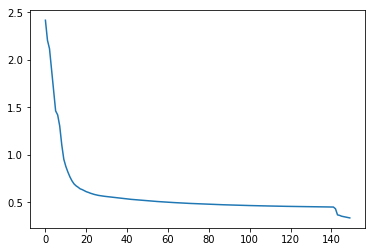

In [8]:
plt.plot(cnn3.loss)

The output seems fine.
But it only hit 90%.
Maybe it is about the size of data.

In [26]:
f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\minist\\mnist_test_10000.csv", 'r')
a = f.readlines()
f.close()
x = []
y = []
count=1
for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])


test_10000_x = np.clip(np.array(x), 0, 1).reshape(10000, 1, 28 ,28)
test_10000_y = np.array(y)
test_25_x=test_10000_x[:25]
test_25_y=test_10000_y[:25]
cnn3.forward(test_25_x)
predicted = cnn3.fc_net.yhat
accuracy = 1.0 - float(len(np.nonzero(predicted - test_25_y)[0])) / len(test_25_y)
print ("Training Accuracy=", accuracy)

Training Accuracy= 0.76


I want to compare the different between two activiation function.

### CNN Train with 100 digits using ReLU

batch_size = 25<br>
epoch = 150<br>
learning rate = 0.075 ~ 0.005 becomes smaller after every epoch<br>
convolutional layer = 2<br>
1st conv_layer --> 4 5x5 kernels<br>
2nd conv_layer --> 8 5x5 kernels<br>
FC_layer = 50 neurals

In [32]:
input_data_spec = [25, 1, 28, 28]

conv_layer_spec = [{"k_num" : 4, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 8, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]

cnn = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)
f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\minist\\mnist_train_100.csv", 'r')
a = f.readlines()
f.close()
x = []
y = []
count=1
for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])


train_100_x = np.clip(np.array(x), 0, 1).reshape(100, 1, 28 ,28)
train_100_y = np.array(y)

t = time.time()
cnn.train(train_100_x, train_100_y, 150, 0.075, 25)
print("Time cost : ", time.time() - t)

Batch: 0  Accuracy: 24.0 %
Batch: 1  Accuracy: 4.0 %
Batch: 2  Accuracy: 16.0 %
Batch: 3  Accuracy: 28.000000000000004 %
Epoch: 0  Accuracy: 18.0 %  loss: 2.2966312493701473
Batch: 0  Accuracy: 20.0 %
Batch: 1  Accuracy: 4.0 %
Batch: 2  Accuracy: 36.0 %
Batch: 3  Accuracy: 24.0 %
Epoch: 1  Accuracy: 21.0 %  loss: 2.2100480960011817
Batch: 0  Accuracy: 32.0 %
Batch: 1  Accuracy: 12.0 %
Batch: 2  Accuracy: 36.0 %
Batch: 3  Accuracy: 32.0 %
Epoch: 2  Accuracy: 28.000000000000004 %  loss: 2.1271821346873665
Batch: 0  Accuracy: 36.0 %
Batch: 1  Accuracy: 8.0 %
Batch: 2  Accuracy: 44.0 %
Batch: 3  Accuracy: 36.0 %
Epoch: 3  Accuracy: 31.0 %  loss: 2.063640254481164
Batch: 0  Accuracy: 32.0 %
Batch: 1  Accuracy: 12.0 %
Batch: 2  Accuracy: 48.0 %
Batch: 3  Accuracy: 44.0 %
Epoch: 4  Accuracy: 34.0 %  loss: 2.000839292635137
Batch: 0  Accuracy: 44.0 %
Batch: 1  Accuracy: 24.0 %
Batch: 2  Accuracy: 60.0 %
Batch: 3  Accuracy: 52.0 %
Epoch: 5  Accuracy: 45.0 %  loss: 1.8698511156570663
Batch: 0  A

Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 50  Accuracy: 92.0 %  loss: 0.3503579705248761
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 51  Accuracy: 92.0 %  loss: 0.34596170438570517
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 52  Accuracy: 92.0 %  loss: 0.3423851640309579
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 53  Accuracy: 92.0 %  loss: 0.33805467295280206
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 54  Accuracy: 92.0 %  loss: 0.33439410927064117
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 96.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 55  Accuracy: 92.0 %  loss: 0.3304312208199298
Batch: 0  Accuracy: 88.0 

Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 100  Accuracy: 93.0 %  loss: 0.22464779105267538
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 101  Accuracy: 93.0 %  loss: 0.22351880646930036
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 102  Accuracy: 93.0 %  loss: 0.22230551932158105
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 103  Accuracy: 93.0 %  loss: 0.22102683377632804
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 104  Accuracy: 93.0 %  loss: 0.21971649176306368
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  Accuracy: 100.0 %
Batch: 3  Accuracy: 92.0 %
Epoch: 105  Accuracy: 93.0 %  loss: 0.21878795559212716
Batch: 0  Accuracy: 88.0 %
Batch: 1  Accuracy: 92.0 %
Batch: 2  

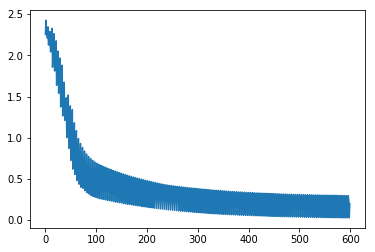

In [33]:
plt.plot(cnn.fc_net.J)

Obviously, the LeakReLU method is better.

In [34]:
cnn.forward(test_25_x)
predicted = cnn3.fc_net.yhat
accuracy = 1.0 - float(len(np.nonzero(predicted - test_25_y)[0])) / len(test_25_y)
print ("Training Accuracy=", accuracy)

Training Accuracy= 0.76


### CNN Train with 60000 digits using leakyRuLU

batch_size = 25<br>
epoch = 150<br>
learning rate = 0.075 ~ 0.005 becomes smaller after every epoch<br>


In [7]:

input_data_spec = [250, 1, 28, 28]
conv_layer_spec = [{"k_num" : 6, "k_h" : 5, "k_w" : 5, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2},
                   {"k_num" : 16, "k_h" : 3, "k_w" : 3, "stride" : 1, "zp" : 0, "mph" : 2,"mpw" :2}]
fc_layer_spec = [400,120, 84, 10]
cnn5 = CNN(input_data_spec=input_data_spec, conv_layer_spec=conv_layer_spec)
f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\minist\\mnist_train_60000.csv", 'r')
a = f.readlines()
f.close()
x = []
y = []
count=1
for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])


train_100_x = np.clip(np.array(x), 0, 1).reshape(60000, 1, 28 ,28)
train_100_y = np.array(y)

t = time.time()
cnn5.train(train_100_x, train_100_y, 150, 0.075, 250)
print("Time cost : ", time.time() - t)


Batch: 0  Accuracy: 12.0 %
Batch: 1  Accuracy: 14.000000000000002 %
Batch: 2  Accuracy: 9.6 %
Batch: 3  Accuracy: 19.6 %
Batch: 4  Accuracy: 8.4 %
Batch: 5  Accuracy: 8.799999999999999 %
Batch: 6  Accuracy: 6.0 %
Batch: 7  Accuracy: 10.0 %
Batch: 8  Accuracy: 16.400000000000002 %
Batch: 9  Accuracy: 13.600000000000001 %
Batch: 10  Accuracy: 14.000000000000002 %
Batch: 11  Accuracy: 14.799999999999999 %
Batch: 12  Accuracy: 18.8 %
Batch: 13  Accuracy: 12.4 %
Batch: 14  Accuracy: 13.600000000000001 %
Batch: 15  Accuracy: 14.000000000000002 %
Batch: 16  Accuracy: 12.8 %
Batch: 17  Accuracy: 14.799999999999999 %
Batch: 18  Accuracy: 12.8 %
Batch: 19  Accuracy: 11.600000000000001 %
Batch: 20  Accuracy: 12.0 %
Batch: 21  Accuracy: 14.000000000000002 %
Batch: 22  Accuracy: 10.4 %
Batch: 23  Accuracy: 12.4 %
Batch: 24  Accuracy: 21.6 %
Batch: 25  Accuracy: 19.2 %
Batch: 26  Accuracy: 25.6 %
Batch: 27  Accuracy: 23.599999999999998 %
Batch: 28  Accuracy: 20.0 %
Batch: 29  Accuracy: 16.8 %
Batch:

Batch: 6  Accuracy: 96.8 %
Batch: 7  Accuracy: 96.8 %
Batch: 8  Accuracy: 96.8 %
Batch: 9  Accuracy: 97.2 %
Batch: 10  Accuracy: 94.8 %
Batch: 11  Accuracy: 97.2 %
Batch: 12  Accuracy: 97.6 %
Batch: 13  Accuracy: 96.8 %
Batch: 14  Accuracy: 95.19999999999999 %
Batch: 15  Accuracy: 96.0 %
Batch: 16  Accuracy: 94.8 %
Batch: 17  Accuracy: 94.39999999999999 %
Batch: 18  Accuracy: 95.6 %
Batch: 19  Accuracy: 96.39999999999999 %
Batch: 20  Accuracy: 94.8 %
Batch: 21  Accuracy: 96.39999999999999 %
Batch: 22  Accuracy: 96.0 %
Batch: 23  Accuracy: 95.19999999999999 %
Batch: 24  Accuracy: 98.0 %
Batch: 25  Accuracy: 94.8 %
Batch: 26  Accuracy: 96.0 %
Batch: 27  Accuracy: 93.60000000000001 %
Batch: 28  Accuracy: 92.80000000000001 %
Batch: 29  Accuracy: 95.19999999999999 %
Batch: 30  Accuracy: 96.39999999999999 %
Batch: 31  Accuracy: 94.0 %
Batch: 32  Accuracy: 94.39999999999999 %
Batch: 33  Accuracy: 91.60000000000001 %
Batch: 34  Accuracy: 92.0 %
Batch: 35  Accuracy: 87.6 %
Batch: 36  Accuracy: 

Batch: 25  Accuracy: 95.19999999999999 %
Batch: 26  Accuracy: 96.8 %
Batch: 27  Accuracy: 94.39999999999999 %
Batch: 28  Accuracy: 95.6 %
Batch: 29  Accuracy: 96.8 %
Batch: 30  Accuracy: 96.8 %
Batch: 31  Accuracy: 98.0 %
Batch: 32  Accuracy: 94.8 %
Batch: 33  Accuracy: 93.2 %
Batch: 34  Accuracy: 94.39999999999999 %
Batch: 35  Accuracy: 92.4 %
Batch: 36  Accuracy: 96.8 %
Batch: 37  Accuracy: 94.8 %
Batch: 38  Accuracy: 96.8 %
Batch: 39  Accuracy: 99.2 %
Batch: 40  Accuracy: 93.60000000000001 %
Batch: 41  Accuracy: 96.8 %
Batch: 42  Accuracy: 98.8 %
Batch: 43  Accuracy: 96.39999999999999 %
Batch: 44  Accuracy: 98.0 %
Batch: 45  Accuracy: 99.2 %
Batch: 46  Accuracy: 97.2 %
Batch: 47  Accuracy: 96.8 %
Batch: 48  Accuracy: 95.6 %
Batch: 49  Accuracy: 97.6 %
Batch: 50  Accuracy: 95.6 %
Batch: 51  Accuracy: 95.19999999999999 %
Batch: 52  Accuracy: 95.19999999999999 %
Batch: 53  Accuracy: 97.2 %
Batch: 54  Accuracy: 96.39999999999999 %
Batch: 55  Accuracy: 96.8 %
Batch: 56  Accuracy: 97.6 %


Batch: 56  Accuracy: 98.0 %
Batch: 57  Accuracy: 97.6 %
Batch: 58  Accuracy: 98.8 %
Batch: 59  Accuracy: 97.2 %
Batch: 60  Accuracy: 98.8 %
Batch: 61  Accuracy: 97.2 %
Batch: 62  Accuracy: 98.8 %
Batch: 63  Accuracy: 94.8 %
Batch: 64  Accuracy: 98.4 %
Batch: 65  Accuracy: 98.8 %
Batch: 66  Accuracy: 96.39999999999999 %
Batch: 67  Accuracy: 98.0 %
Batch: 68  Accuracy: 96.39999999999999 %
Batch: 69  Accuracy: 98.4 %
Batch: 70  Accuracy: 97.6 %
Batch: 71  Accuracy: 96.8 %
Batch: 72  Accuracy: 97.6 %
Batch: 73  Accuracy: 98.0 %
Batch: 74  Accuracy: 98.4 %
Batch: 75  Accuracy: 99.2 %
Batch: 76  Accuracy: 98.0 %
Batch: 77  Accuracy: 96.39999999999999 %
Batch: 78  Accuracy: 98.0 %
Batch: 79  Accuracy: 99.2 %
Batch: 80  Accuracy: 97.6 %
Batch: 81  Accuracy: 99.6 %
Batch: 82  Accuracy: 97.2 %
Batch: 83  Accuracy: 97.2 %
Batch: 84  Accuracy: 98.0 %
Batch: 85  Accuracy: 98.4 %
Batch: 86  Accuracy: 98.4 %
Batch: 87  Accuracy: 96.0 %
Batch: 88  Accuracy: 97.2 %
Batch: 89  Accuracy: 98.8 %
Batch: 90

Batch: 96  Accuracy: 98.0 %
Batch: 97  Accuracy: 98.8 %
Batch: 98  Accuracy: 99.2 %
Batch: 99  Accuracy: 98.8 %
Batch: 100  Accuracy: 97.6 %
Batch: 101  Accuracy: 97.2 %
Batch: 102  Accuracy: 98.8 %
Batch: 103  Accuracy: 97.6 %
Batch: 104  Accuracy: 98.4 %
Batch: 105  Accuracy: 98.0 %
Batch: 106  Accuracy: 94.8 %
Batch: 107  Accuracy: 98.8 %
Batch: 108  Accuracy: 97.6 %
Batch: 109  Accuracy: 98.4 %
Batch: 110  Accuracy: 97.2 %
Batch: 111  Accuracy: 98.8 %
Batch: 112  Accuracy: 98.4 %
Batch: 113  Accuracy: 98.0 %
Batch: 114  Accuracy: 97.2 %
Batch: 115  Accuracy: 98.8 %
Batch: 116  Accuracy: 98.0 %
Batch: 117  Accuracy: 98.0 %
Batch: 118  Accuracy: 99.2 %
Batch: 119  Accuracy: 98.8 %
Batch: 120  Accuracy: 97.6 %
Batch: 121  Accuracy: 99.2 %
Batch: 122  Accuracy: 98.0 %
Batch: 123  Accuracy: 97.2 %
Batch: 124  Accuracy: 98.4 %
Batch: 125  Accuracy: 97.2 %
Batch: 126  Accuracy: 96.0 %
Batch: 127  Accuracy: 97.2 %
Batch: 128  Accuracy: 98.0 %
Batch: 129  Accuracy: 96.8 %
Batch: 130  Accura

Batch: 137  Accuracy: 98.8 %
Batch: 138  Accuracy: 97.2 %
Batch: 139  Accuracy: 97.2 %
Batch: 140  Accuracy: 98.4 %
Batch: 141  Accuracy: 98.4 %
Batch: 142  Accuracy: 98.4 %
Batch: 143  Accuracy: 98.8 %
Batch: 144  Accuracy: 97.6 %
Batch: 145  Accuracy: 98.0 %
Batch: 146  Accuracy: 97.6 %
Batch: 147  Accuracy: 97.6 %
Batch: 148  Accuracy: 97.2 %
Batch: 149  Accuracy: 97.6 %
Batch: 150  Accuracy: 98.4 %
Batch: 151  Accuracy: 97.6 %
Batch: 152  Accuracy: 99.2 %
Batch: 153  Accuracy: 98.0 %
Batch: 154  Accuracy: 98.4 %
Batch: 155  Accuracy: 99.2 %
Batch: 156  Accuracy: 99.2 %
Batch: 157  Accuracy: 95.6 %
Batch: 158  Accuracy: 97.6 %
Batch: 159  Accuracy: 98.8 %
Batch: 160  Accuracy: 98.8 %
Batch: 161  Accuracy: 98.8 %
Batch: 162  Accuracy: 99.2 %
Batch: 163  Accuracy: 98.0 %
Batch: 164  Accuracy: 98.8 %
Batch: 165  Accuracy: 96.8 %
Batch: 166  Accuracy: 98.4 %
Batch: 167  Accuracy: 98.0 %
Batch: 168  Accuracy: 96.8 %
Batch: 169  Accuracy: 98.4 %
Batch: 170  Accuracy: 98.4 %
Batch: 171  Ac

Batch: 180  Accuracy: 98.8 %
Batch: 181  Accuracy: 98.0 %
Batch: 182  Accuracy: 98.0 %
Batch: 183  Accuracy: 97.2 %
Batch: 184  Accuracy: 97.2 %
Batch: 185  Accuracy: 95.19999999999999 %
Batch: 186  Accuracy: 98.4 %
Batch: 187  Accuracy: 98.8 %
Batch: 188  Accuracy: 98.4 %
Batch: 189  Accuracy: 97.6 %
Batch: 190  Accuracy: 96.8 %
Batch: 191  Accuracy: 98.4 %
Batch: 192  Accuracy: 98.0 %
Batch: 193  Accuracy: 98.4 %
Batch: 194  Accuracy: 99.6 %
Batch: 195  Accuracy: 98.0 %
Batch: 196  Accuracy: 97.6 %
Batch: 197  Accuracy: 99.2 %
Batch: 198  Accuracy: 97.2 %
Batch: 199  Accuracy: 96.8 %
Batch: 200  Accuracy: 97.6 %
Batch: 201  Accuracy: 98.0 %
Batch: 202  Accuracy: 98.8 %
Batch: 203  Accuracy: 98.0 %
Batch: 204  Accuracy: 98.8 %
Batch: 205  Accuracy: 98.0 %
Batch: 206  Accuracy: 99.6 %
Batch: 207  Accuracy: 97.6 %
Batch: 208  Accuracy: 97.2 %
Batch: 209  Accuracy: 98.4 %
Batch: 210  Accuracy: 99.6 %
Batch: 211  Accuracy: 98.0 %
Batch: 212  Accuracy: 98.4 %
Batch: 213  Accuracy: 99.6 %
B

Batch: 223  Accuracy: 99.2 %
Batch: 224  Accuracy: 99.2 %
Batch: 225  Accuracy: 98.8 %
Batch: 226  Accuracy: 98.8 %
Batch: 227  Accuracy: 98.0 %
Batch: 228  Accuracy: 98.8 %
Batch: 229  Accuracy: 98.0 %
Batch: 230  Accuracy: 98.4 %
Batch: 231  Accuracy: 99.2 %
Batch: 232  Accuracy: 99.2 %
Batch: 233  Accuracy: 99.6 %
Batch: 234  Accuracy: 99.6 %
Batch: 235  Accuracy: 98.4 %
Batch: 236  Accuracy: 100.0 %
Batch: 237  Accuracy: 99.6 %
Batch: 238  Accuracy: 97.2 %
Batch: 239  Accuracy: 99.6 %
Epoch: 7  Accuracy: 98.48666666666666 %  loss: 0.04955412420137391
Batch: 0  Accuracy: 97.6 %
Batch: 1  Accuracy: 98.8 %
Batch: 2  Accuracy: 98.8 %
Batch: 3  Accuracy: 97.6 %
Batch: 4  Accuracy: 98.4 %
Batch: 5  Accuracy: 97.6 %
Batch: 6  Accuracy: 99.2 %
Batch: 7  Accuracy: 98.4 %
Batch: 8  Accuracy: 99.6 %
Batch: 9  Accuracy: 99.6 %
Batch: 10  Accuracy: 98.0 %
Batch: 11  Accuracy: 100.0 %
Batch: 12  Accuracy: 99.2 %
Batch: 13  Accuracy: 99.6 %
Batch: 14  Accuracy: 98.0 %
Batch: 15  Accuracy: 99.2 %


KeyboardInterrupt: 

### MLP Train with 60000 digits using leakyReLU

batch_size = 100<br>
epoch = 10000<br>
learning rate = 0.1 <br>
Eta = 0.00001

In [93]:
f = open("C:\\Users\\Herry\\Desktop\\十大重要演算法\\Neural Net\\minist\\mnist_train_60000.csv", 'r')
a = f.readlines()
f.close()

%matplotlib inline
import matplotlib.pylab as plt
x = []
y = []
count=1
for line in a:
    linebits = line.split(',')
    x_line = [int(linebits[i]) for i in range(len(linebits))]
    x.append(x_line[1:])
    y.append(x_line[0])

train_60000_x = np.array(x).T
train_60000_y = np.array(y)

In [96]:
Layers = (784, 50, 10)
BatchSize = 100
EpochCount = 1000
LearningRate = 0.1
Eta = 0.00001

mlp60000 = MLP(Layers, BatchSize)
t = time.time()
mlp60000.train(train_60000_x, train_60000_y, EpochCount, LearningRate, Eta)
print("Time cost : ", time.time() - t)

Epoch  0
Training Accuracy= 0.5800000000000001 loss =  1.3283172753469286
Epoch  1
Training Accuracy= 0.73 loss =  0.9769998353342552
Epoch  2
Training Accuracy= 0.76 loss =  0.7915607635621521
Epoch  3
Training Accuracy= 0.8 loss =  0.6767651655873393
Epoch  4
Training Accuracy= 0.81 loss =  0.6165497878888615
Epoch  5
Training Accuracy= 0.83 loss =  0.5777390255015582
Epoch  6
Training Accuracy= 0.84 loss =  0.5516322658465923
Epoch  7
Training Accuracy= 0.84 loss =  0.533071033438443
Epoch  8
Training Accuracy= 0.85 loss =  0.5192418826313333
Epoch  9
Training Accuracy= 0.85 loss =  0.5087690686212121
Epoch  10
Training Accuracy= 0.85 loss =  0.5003295076828531
Epoch  11
Training Accuracy= 0.87 loss =  0.4612341066670279
Epoch  12
Training Accuracy= 0.94 loss =  0.28005691582242775
Epoch  13
Training Accuracy= 0.94 loss =  0.25149847065757847
Epoch  14
Training Accuracy= 0.95 loss =  0.244662750611261
Epoch  15
Training Accuracy= 0.95 loss =  0.2424847086495012
Epoch  16
Training Ac

Training Accuracy= 0.97 loss =  0.18385041851150583
Epoch  134
Training Accuracy= 0.97 loss =  0.18324149216628194
Epoch  135
Training Accuracy= 0.97 loss =  0.18266500893886145
Epoch  136
Training Accuracy= 0.97 loss =  0.18210760266273185
Epoch  137
Training Accuracy= 0.97 loss =  0.18153587841710006
Epoch  138
Training Accuracy= 0.97 loss =  0.18092178750896826
Epoch  139
Training Accuracy= 0.97 loss =  0.1803354590754298
Epoch  140
Training Accuracy= 0.97 loss =  0.17970678820608812
Epoch  141
Training Accuracy= 0.97 loss =  0.1791071718492589
Epoch  142
Training Accuracy= 0.97 loss =  0.17846862455555734
Epoch  143
Training Accuracy= 0.97 loss =  0.1778693453347735
Epoch  144
Training Accuracy= 0.97 loss =  0.17727883954177273
Epoch  145
Training Accuracy= 0.97 loss =  0.17667002324625483
Epoch  146
Training Accuracy= 0.97 loss =  0.17613510012962103
Epoch  147
Training Accuracy= 0.97 loss =  0.17555713816865634
Epoch  148
Training Accuracy= 0.97 loss =  0.1751011353048409
Epoch  

Training Accuracy= 0.97 loss =  0.1400026319881788
Epoch  265
Training Accuracy= 0.97 loss =  0.13967495742724978
Epoch  266
Training Accuracy= 0.97 loss =  0.13932969590296224
Epoch  267
Training Accuracy= 0.97 loss =  0.1389930038485824
Epoch  268
Training Accuracy= 0.97 loss =  0.13863344864318228
Epoch  269
Training Accuracy= 0.97 loss =  0.13824346444839247
Epoch  270
Training Accuracy= 0.97 loss =  0.1378768299546751
Epoch  271
Training Accuracy= 0.97 loss =  0.13753657623273402
Epoch  272
Training Accuracy= 0.97 loss =  0.13708399403855626
Epoch  273
Training Accuracy= 0.97 loss =  0.1366546479399247
Epoch  274
Training Accuracy= 0.97 loss =  0.13618585436275235
Epoch  275
Training Accuracy= 0.97 loss =  0.13575710493771298
Epoch  276
Training Accuracy= 0.97 loss =  0.13535906657264113
Epoch  277
Training Accuracy= 0.97 loss =  0.1349180626597442
Epoch  278
Training Accuracy= 0.97 loss =  0.1344370908686206
Epoch  279
Training Accuracy= 0.97 loss =  0.13381345789856247
Epoch  28

Training Accuracy= 0.97 loss =  0.09948539599446683
Epoch  396
Training Accuracy= 0.97 loss =  0.09954223873640737
Epoch  397
Training Accuracy= 0.97 loss =  0.09958326595550951
Epoch  398
Training Accuracy= 0.97 loss =  0.09954417692345904
Epoch  399
Training Accuracy= 0.97 loss =  0.09952730386059344
Epoch  400
Training Accuracy= 0.97 loss =  0.09952187059094408
Epoch  401
Training Accuracy= 0.97 loss =  0.09958730353318694
Epoch  402
Training Accuracy= 0.97 loss =  0.09960994513597958
Epoch  403
Training Accuracy= 0.97 loss =  0.09961535135890333
Epoch  404
Training Accuracy= 0.97 loss =  0.09969518159813545
Epoch  405
Training Accuracy= 0.97 loss =  0.09981284101225434
Epoch  406
Training Accuracy= 0.97 loss =  0.09985428149796108
Epoch  407
Training Accuracy= 0.97 loss =  0.0999218450026167
Epoch  408
Training Accuracy= 0.97 loss =  0.1000040526915505
Epoch  409
Training Accuracy= 0.97 loss =  0.10011651807083809
Epoch  410
Training Accuracy= 0.97 loss =  0.1002248898260637
Epoch 

Training Accuracy= 0.97 loss =  0.11331884717170536
Epoch  527
Training Accuracy= 0.97 loss =  0.11350560271558084
Epoch  528
Training Accuracy= 0.97 loss =  0.11359924226677616
Epoch  529
Training Accuracy= 0.97 loss =  0.11383148459090035
Epoch  530
Training Accuracy= 0.97 loss =  0.11405285981377702
Epoch  531
Training Accuracy= 0.97 loss =  0.11432504524479407
Epoch  532
Training Accuracy= 0.97 loss =  0.11448485051033569
Epoch  533
Training Accuracy= 0.97 loss =  0.11443809279904313
Epoch  534
Training Accuracy= 0.97 loss =  0.11456305131937872
Epoch  535
Training Accuracy= 0.97 loss =  0.11476504968918165
Epoch  536
Training Accuracy= 0.97 loss =  0.11487233853645568
Epoch  537
Training Accuracy= 0.97 loss =  0.1146005850448132
Epoch  538
Training Accuracy= 0.97 loss =  0.11433131517941089
Epoch  539
Training Accuracy= 0.97 loss =  0.11432873358304725
Epoch  540
Training Accuracy= 0.97 loss =  0.11448447808538355
Epoch  541
Training Accuracy= 0.97 loss =  0.11460593892496353
Epoc

Training Accuracy= 0.97 loss =  0.14781180409535516
Epoch  658
Training Accuracy= 0.97 loss =  0.14820401173820572
Epoch  659
Training Accuracy= 0.97 loss =  0.14850117397965454
Epoch  660
Training Accuracy= 0.97 loss =  0.1488056626505993
Epoch  661
Training Accuracy= 0.97 loss =  0.149379934863642
Epoch  662
Training Accuracy= 0.97 loss =  0.15030590880140643
Epoch  663
Training Accuracy= 0.97 loss =  0.1506842199711203
Epoch  664
Training Accuracy= 0.97 loss =  0.1509404397276886
Epoch  665
Training Accuracy= 0.97 loss =  0.15125040996512462
Epoch  666
Training Accuracy= 0.97 loss =  0.15151208664638693
Epoch  667
Training Accuracy= 0.97 loss =  0.15179578682165373
Epoch  668
Training Accuracy= 0.97 loss =  0.15204246250341225
Epoch  669
Training Accuracy= 0.97 loss =  0.1523394854153931
Epoch  670
Training Accuracy= 0.97 loss =  0.15261231725735022
Epoch  671
Training Accuracy= 0.97 loss =  0.15286816412733495
Epoch  672
Training Accuracy= 0.97 loss =  0.15310577835695988
Epoch  67

Training Accuracy= 0.97 loss =  0.11336203472184536
Epoch  789
Training Accuracy= 0.97 loss =  0.113290019797707
Epoch  790
Training Accuracy= 0.97 loss =  0.11319597107886481
Epoch  791
Training Accuracy= 0.97 loss =  0.113071742889708
Epoch  792
Training Accuracy= 0.97 loss =  0.11317847869328748
Epoch  793
Training Accuracy= 0.97 loss =  0.11333639374281332
Epoch  794
Training Accuracy= 0.97 loss =  0.11340921217182655
Epoch  795
Training Accuracy= 0.97 loss =  0.11389899631923324
Epoch  796
Training Accuracy= 0.97 loss =  0.11399448024001611
Epoch  797
Training Accuracy= 0.97 loss =  0.11409645320557893
Epoch  798
Training Accuracy= 0.97 loss =  0.11421606691436749
Epoch  799
Training Accuracy= 0.97 loss =  0.11433541067358005
Epoch  800
Training Accuracy= 0.97 loss =  0.11440122844217498
Epoch  801
Training Accuracy= 0.97 loss =  0.11450149405676902
Epoch  802
Training Accuracy= 0.97 loss =  0.11464244731847527
Epoch  803
Training Accuracy= 0.97 loss =  0.11478489420932522
Epoch  

Training Accuracy= 0.97 loss =  0.11572171888305158
Epoch  920
Training Accuracy= 0.97 loss =  0.11548494408534189
Epoch  921
Training Accuracy= 0.97 loss =  0.11526178991329797
Epoch  922
Training Accuracy= 0.97 loss =  0.11502911697011706
Epoch  923
Training Accuracy= 0.97 loss =  0.11499253133282006
Epoch  924
Training Accuracy= 0.97 loss =  0.11472400774472857
Epoch  925
Training Accuracy= 0.97 loss =  0.11439558778185714
Epoch  926
Training Accuracy= 0.97 loss =  0.11410269651965421
Epoch  927
Training Accuracy= 0.97 loss =  0.11388158912544719
Epoch  928
Training Accuracy= 0.97 loss =  0.11359822623169837
Epoch  929
Training Accuracy= 0.97 loss =  0.1133505706418215
Epoch  930
Training Accuracy= 0.97 loss =  0.11309281279453687
Epoch  931
Training Accuracy= 0.97 loss =  0.11284337723018044
Epoch  932
Training Accuracy= 0.97 loss =  0.1125953461577888
Epoch  933
Training Accuracy= 0.97 loss =  0.1121823468390401
Epoch  934
Training Accuracy= 0.97 loss =  0.11191007693940289
Epoch 

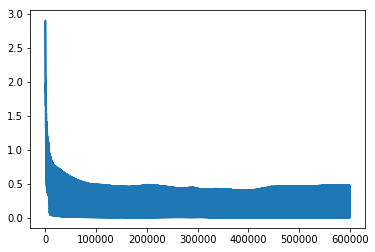

In [97]:
plt.plot(mlp60000.J)

Conclusion:

I have tried more than 100 times of every parameters.<br>
I found that batch size around 25~50 can get a better result and converge faster.<br>
Epoch count can set a larger number to make the training continue to a convergent result.<br>
Maybe we can set a stop condition when loss value is almost not changing for a long time.<br>
Learning rate also effects the loss value's convergent.<br>
My code is now trying momentum learning rate.<br>
Learning rate decreases after every epoch, and stop decreasing at lr=0.001<br>
This setting helps the speed of convergent.<br>
Finally, this lab is a great example to learn how machine works and the parameters meanings inside the model.<br>